In [11]:
from numpy import zeros, ones
import numpy as np
from numpy.random import randn, randint

from keras.datasets.cifar10 import load_data

from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout

from matplotlib import pyplot

### Define standalone Generator

In [7]:
def define_generator(latent_dim):
    gen = Sequential(name='Generator')
    
    # foundation of 4x4 image
    n_nodes = 4*4*256
    
    gen.add(Dense(n_nodes, input_dim=latent_dim))
    gen.add(LeakyReLU(alpha=0.2))
    gen.add(Reshape((4, 4, 256)))
    
    # upsample to 8x8x128
    gen.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16x128
    gen.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32x128
    gen.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
    gen.add(LeakyReLU(alpha=0.2))
    
    # output layer 32x32x3
    gen.add(Conv2D(3, (3, 3), activation='tanh', padding='same'))
    
    return gen

gen_demo = define_generator(100)
gen_demo.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 4096)              413696    
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         295040    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 16, 16, 128)       147584    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 128)       0 

### Define standalone discriminator

In [9]:
def define_discriminator(in_shape=(32, 32, 3)):
    dis = Sequential(name='Discriminator')
    
    # normal -> 32x32x64
    dis.add(Conv2D(64, (3, 3), padding='same', input_shape=in_shape))
    dis.add(LeakyReLU(alpha=0.2))
    
    # downsample -> 16x16x128
    dis.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    dis.add(LeakyReLU(alpha=0.2))
    
    # downsample -> 8x8x128
    dis.add(Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    dis.add(LeakyReLU(alpha=0.2))
    
    # downsample -> 4x4x256
    dis.add(Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    dis.add(LeakyReLU(alpha=0.2))
    
    # classifier
    dis.add(Flatten())
    dis.add(Dense(1, activation='sigmoid'))
    
    # compile model
    opt = Adam(lr = 0.0002, beta_1=0.5)
    dis.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return dis

dis_demo = define_discriminator()
dis_demo.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 256)       

### Define GAN

In [10]:
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    
    # connect them
    gan = Sequential(name='GAN')
    
    gan.add(g_model)
    gan.add(d_model)
    
    # compile model
    opt = Adam(lr = 0.0002, beta_1 = 0.5)
    
    gan.compile(loss='binary_crossentropy', optimizer=opt)
    
    return gan

In [21]:
def get_cifar():
    (images, _), (_, _) = load_data()
    images = images.astype('float32')
    
    # scale from [0, 255] to [-1, 1]
    images = (images-127.5) / 127.5
    
    return images

In [13]:
# select real samples

def generate_real_samples(dataset, n_samples):
    # choose random index of dataset
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[ix]
    y = ones((n_samples, 1))
    
    return X, y

In [14]:
# generate points in latent space as input for the generator

def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape((n_samples, latent_dim))
    
    return x_input

In [15]:
# generate n fake samples with class labels

def generate_fake_samples(g_model, latent_dim, n_samples):
    
    X = generate_latent_points(latent_dim, n_samples)
    # reshape generated data into gray scale
    X = g_model.predict(X)
    # generate class labels for fake images
    y = np.zeros((n_samples, 1))
    
    return X, y

In [16]:
# summarize performance

def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
     
        # prepare real samples
        X_real, y_real = generate_real_samples(dataset, n_samples)
        # evaluate discriminator on real samples
        _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
        
        # prepare fake samples
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
        # evaluate discriminator on fake examples
        _, acc_fake = d_model.evaluate(X_fake, y_fake, verbose=0)
        
        # summarize the discriminator performance
        print('\n>Acc for real sample: %.0f%%\nAcc for fake sample: %.0f%%' % (acc_real*100, acc_fake*100))
        
        # save the generator model file
        filename = 'generator_model_%03d.h5' % (epoch + 1)
        g_model.save(filename)

In [17]:
# train the discriminator

def trainGAN(g_model, d_model, gan, dataset, latent_dim, n_epochs=200, n_batch=128):
    batch_per_epoch = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch/2)
    
    for i in range(n_epochs):
        for j in range(batch_per_epoch):
            X_real, y_real = generate_real_samples(dataset, half_batch)
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            
            X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
            
            d_loss, _ = d_model.train_on_batch(X, y)
            
            X_gan = generate_latent_points(latent_dim, n_batch)
            y_gan = np.ones((n_batch, 1))
            
            # update the generator via the discriminator's error
            g_loss = gan.train_on_batch(X_gan, y_gan)
            
            print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss, g_loss))
            
        # evaluate the model performance sometimes
        if (i+1)%10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)

In [22]:
latent_dim = 100
d_model = define_discriminator()
g_model = define_generator(latent_dim)

gan = define_gan(g_model, d_model)

# load image data
dataset = get_cifar()

d_model.summary()
g_model.summary()
gan.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_30 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 256)       

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


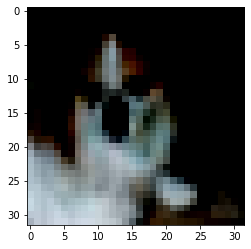

In [36]:
a, _ = generate_real_samples(dataset, 1)
pyplot.imshow(a[0])

## Train GAN

In [ ]:
trainGAN(g_model, d_model, gan, dataset, latent_dim)

>1, 1/390, d=0.698, g=0.693
>1, 2/390, d=0.674, g=0.692
>1, 3/390, d=0.651, g=0.690
>1, 4/390, d=0.621, g=0.687
>1, 5/390, d=0.594, g=0.678
>1, 6/390, d=0.555, g=0.661
>1, 7/390, d=0.539, g=0.638
>1, 8/390, d=0.522, g=0.619
>1, 9/390, d=0.509, g=0.623
>1, 10/390, d=0.478, g=0.666
>1, 11/390, d=0.436, g=0.754
>1, 12/390, d=0.377, g=0.853
>1, 13/390, d=0.350, g=0.910
>1, 14/390, d=0.333, g=0.916
>1, 15/390, d=0.321, g=0.892
>1, 16/390, d=0.313, g=0.860
>1, 17/390, d=0.329, g=0.828
>1, 18/390, d=0.330, g=0.803
>1, 19/390, d=0.343, g=0.783
>1, 20/390, d=0.387, g=0.748
>1, 21/390, d=0.436, g=0.687
>1, 22/390, d=0.494, g=0.638
>1, 23/390, d=0.538, g=0.639
>1, 24/390, d=0.536, g=0.691
>1, 25/390, d=0.464, g=0.787
>1, 26/390, d=0.389, g=0.915
>1, 27/390, d=0.327, g=1.045
>1, 28/390, d=0.306, g=1.124
>1, 29/390, d=0.276, g=1.127
>1, 30/390, d=0.263, g=1.119
>1, 31/390, d=0.282, g=1.108
>1, 32/390, d=0.267, g=1.107
>1, 33/390, d=0.284, g=1.034
>1, 34/390, d=0.303, g=1.025
>1, 35/390, d=0.331, g=

>1, 279/390, d=0.566, g=2.101
>1, 280/390, d=0.531, g=2.073
>1, 281/390, d=0.751, g=1.838
>1, 282/390, d=1.061, g=2.606
>1, 283/390, d=0.462, g=3.684
>1, 284/390, d=0.276, g=4.103
>1, 285/390, d=0.208, g=3.941
>1, 286/390, d=0.188, g=3.523
>1, 287/390, d=0.220, g=2.589
>1, 288/390, d=0.365, g=3.996
>1, 289/390, d=0.316, g=3.510
>1, 290/390, d=0.359, g=2.958
>1, 291/390, d=0.278, g=2.371
>1, 292/390, d=0.348, g=2.277
>1, 293/390, d=0.436, g=1.905
>1, 294/390, d=0.431, g=1.965
>1, 295/390, d=0.543, g=1.511
>1, 296/390, d=0.671, g=1.304
>1, 297/390, d=0.692, g=1.073
>1, 298/390, d=0.672, g=0.918
>1, 299/390, d=0.694, g=1.039
>1, 300/390, d=0.509, g=1.122
>1, 301/390, d=0.625, g=1.118
>1, 302/390, d=0.507, g=1.143
>1, 303/390, d=0.494, g=1.149
>1, 304/390, d=0.439, g=1.158
>1, 305/390, d=0.446, g=1.205
>1, 306/390, d=0.404, g=1.274
>1, 307/390, d=0.392, g=1.215
>1, 308/390, d=0.426, g=1.436
>1, 309/390, d=0.452, g=1.542
>1, 310/390, d=0.393, g=1.462
>1, 311/390, d=0.414, g=1.362
>1, 312/39

>2, 167/390, d=0.390, g=2.253
>2, 168/390, d=0.370, g=1.771
>2, 169/390, d=0.419, g=1.996
>2, 170/390, d=0.365, g=2.297
>2, 171/390, d=0.412, g=1.880
>2, 172/390, d=0.392, g=1.925
>2, 173/390, d=0.411, g=1.643
>2, 174/390, d=0.458, g=1.980
>2, 175/390, d=0.436, g=1.838
>2, 176/390, d=0.390, g=1.911
>2, 177/390, d=0.352, g=2.031
>2, 178/390, d=0.434, g=1.810
>2, 179/390, d=0.481, g=1.767
>2, 180/390, d=0.411, g=1.578
>2, 181/390, d=0.430, g=2.007
>2, 182/390, d=0.483, g=1.680
>2, 183/390, d=0.493, g=1.943
>2, 184/390, d=0.421, g=2.287
>2, 185/390, d=0.372, g=1.951
>2, 186/390, d=0.472, g=1.442
>2, 187/390, d=0.498, g=2.620
>2, 188/390, d=0.434, g=1.824
>2, 189/390, d=0.407, g=1.780
>2, 190/390, d=0.462, g=1.690
>2, 191/390, d=0.438, g=2.229
>2, 192/390, d=0.359, g=2.066
>2, 193/390, d=0.368, g=1.311
>2, 194/390, d=0.460, g=2.245
>2, 195/390, d=0.500, g=1.554
>2, 196/390, d=0.487, g=1.949
>2, 197/390, d=0.643, g=1.111
>2, 198/390, d=0.556, g=1.785
>2, 199/390, d=0.528, g=1.465
>2, 200/39

>3, 54/390, d=0.581, g=1.994
>3, 55/390, d=0.583, g=1.165
>3, 56/390, d=0.599, g=1.046
>3, 57/390, d=0.665, g=3.573
>3, 58/390, d=0.691, g=1.716
>3, 59/390, d=0.523, g=1.059
>3, 60/390, d=0.396, g=1.335
>3, 61/390, d=0.459, g=1.649
>3, 62/390, d=0.333, g=1.756
>3, 63/390, d=0.297, g=1.443
>3, 64/390, d=0.325, g=1.500
>3, 65/390, d=0.310, g=1.673
>3, 66/390, d=0.259, g=1.822
>3, 67/390, d=0.309, g=1.702
>3, 68/390, d=0.299, g=1.435
>3, 69/390, d=0.253, g=1.840
>3, 70/390, d=0.237, g=2.090
>3, 71/390, d=0.288, g=1.755
>3, 72/390, d=0.233, g=1.868
>3, 73/390, d=0.217, g=1.963
>3, 74/390, d=0.238, g=1.990
>3, 75/390, d=0.285, g=1.630
>3, 76/390, d=0.273, g=1.857
>3, 77/390, d=0.259, g=1.915
>3, 78/390, d=0.302, g=1.691
>3, 79/390, d=0.307, g=1.742
>3, 80/390, d=0.244, g=2.088
>3, 81/390, d=0.325, g=1.844
>3, 82/390, d=0.346, g=1.761
>3, 83/390, d=0.368, g=1.651
>3, 84/390, d=0.362, g=1.997
>3, 85/390, d=0.404, g=1.842
>3, 86/390, d=0.321, g=2.008
>3, 87/390, d=0.301, g=2.028
>3, 88/390, d=

>3, 330/390, d=0.421, g=1.608
>3, 331/390, d=0.416, g=1.738
>3, 332/390, d=0.360, g=2.201
>3, 333/390, d=0.335, g=2.393
>3, 334/390, d=0.522, g=1.667
>3, 335/390, d=0.429, g=2.189
>3, 336/390, d=0.345, g=2.563
>3, 337/390, d=0.354, g=2.140
>3, 338/390, d=0.482, g=2.022
>3, 339/390, d=0.410, g=2.840
>3, 340/390, d=0.457, g=2.503
>3, 341/390, d=0.660, g=1.658
>3, 342/390, d=0.706, g=2.552
>3, 343/390, d=0.594, g=2.203
>3, 344/390, d=0.567, g=2.016
>3, 345/390, d=0.504, g=2.261
>3, 346/390, d=0.409, g=2.550
>3, 347/390, d=0.491, g=2.171
>3, 348/390, d=0.349, g=2.431
>3, 349/390, d=0.363, g=3.244
>3, 350/390, d=0.357, g=2.723
>3, 351/390, d=0.365, g=1.997
>3, 352/390, d=0.343, g=3.104
>3, 353/390, d=0.349, g=1.875
>3, 354/390, d=0.376, g=4.382
>3, 355/390, d=0.541, g=1.672
>3, 356/390, d=0.398, g=2.009
>3, 357/390, d=0.306, g=3.035
>3, 358/390, d=0.425, g=1.239
>3, 359/390, d=0.508, g=3.277
>3, 360/390, d=0.490, g=2.356
>3, 361/390, d=0.567, g=1.430
>3, 362/390, d=0.831, g=2.330
>3, 363/39

>4, 217/390, d=0.289, g=1.957
>4, 218/390, d=0.234, g=2.098
>4, 219/390, d=0.223, g=2.159
>4, 220/390, d=0.246, g=2.093
>4, 221/390, d=0.290, g=1.813
>4, 222/390, d=0.312, g=1.729
>4, 223/390, d=0.414, g=1.894
>4, 224/390, d=0.471, g=1.726
>4, 225/390, d=0.460, g=1.858
>4, 226/390, d=0.628, g=2.111
>4, 227/390, d=0.764, g=1.774
>4, 228/390, d=0.694, g=1.282
>4, 229/390, d=0.765, g=1.459
>4, 230/390, d=0.693, g=1.578
>4, 231/390, d=0.522, g=1.535
>4, 232/390, d=0.419, g=1.734
>4, 233/390, d=0.313, g=1.938
>4, 234/390, d=0.294, g=2.022
>4, 235/390, d=0.247, g=2.094
>4, 236/390, d=0.242, g=2.060
>4, 237/390, d=0.297, g=2.159
>4, 238/390, d=0.268, g=2.256
>4, 239/390, d=0.244, g=2.245
>4, 240/390, d=0.300, g=1.763
>4, 241/390, d=0.340, g=2.186
>4, 242/390, d=0.397, g=2.137
>4, 243/390, d=0.536, g=1.426
>4, 244/390, d=0.573, g=1.238
>4, 245/390, d=0.482, g=2.088
>4, 246/390, d=0.456, g=1.419
>4, 247/390, d=0.400, g=1.509
>4, 248/390, d=0.466, g=1.514
>4, 249/390, d=0.464, g=1.567
>4, 250/39

>5, 104/390, d=0.357, g=1.527
>5, 105/390, d=0.490, g=2.050
>5, 106/390, d=0.455, g=1.837
>5, 107/390, d=0.570, g=1.396
>5, 108/390, d=0.484, g=1.937
>5, 109/390, d=0.603, g=0.984
>5, 110/390, d=0.668, g=2.039
>5, 111/390, d=0.649, g=1.006
>5, 112/390, d=0.547, g=1.124
>5, 113/390, d=0.553, g=1.577
>5, 114/390, d=0.553, g=1.287
>5, 115/390, d=0.509, g=1.252
>5, 116/390, d=0.514, g=1.557
>5, 117/390, d=0.551, g=1.039
>5, 118/390, d=0.428, g=1.586
>5, 119/390, d=0.404, g=1.963
>5, 120/390, d=0.396, g=1.444
>5, 121/390, d=0.388, g=1.541
>5, 122/390, d=0.456, g=1.687
>5, 123/390, d=0.417, g=1.614
>5, 124/390, d=0.499, g=1.281
>5, 125/390, d=0.591, g=1.841
>5, 126/390, d=0.579, g=1.229
>5, 127/390, d=0.596, g=1.159
>5, 128/390, d=0.579, g=1.284
>5, 129/390, d=0.632, g=1.000
>5, 130/390, d=0.599, g=1.256
>5, 131/390, d=0.557, g=1.242
>5, 132/390, d=0.568, g=1.181
>5, 133/390, d=0.539, g=1.048
>5, 134/390, d=0.561, g=1.280
>5, 135/390, d=0.511, g=1.280
>5, 136/390, d=0.562, g=0.969
>5, 137/39

>5, 379/390, d=0.845, g=1.060
>5, 380/390, d=0.792, g=0.979
>5, 381/390, d=0.776, g=1.106
>5, 382/390, d=0.844, g=0.924
>5, 383/390, d=0.717, g=1.160
>5, 384/390, d=0.627, g=1.179
>5, 385/390, d=0.596, g=1.047
>5, 386/390, d=0.563, g=1.583
>5, 387/390, d=0.534, g=1.473
>5, 388/390, d=0.439, g=1.325
>5, 389/390, d=0.421, g=1.408
>5, 390/390, d=0.393, g=1.506
>6, 1/390, d=0.390, g=1.603
>6, 2/390, d=0.374, g=1.491
>6, 3/390, d=0.406, g=1.493
>6, 4/390, d=0.430, g=1.637
>6, 5/390, d=0.436, g=1.368
>6, 6/390, d=0.431, g=1.766
>6, 7/390, d=0.457, g=1.400
>6, 8/390, d=0.515, g=1.266
>6, 9/390, d=0.499, g=1.280
>6, 10/390, d=0.553, g=1.693
>6, 11/390, d=0.561, g=1.013
>6, 12/390, d=0.604, g=1.442
>6, 13/390, d=0.493, g=1.229
>6, 14/390, d=0.535, g=1.500
>6, 15/390, d=0.561, g=1.153
>6, 16/390, d=0.523, g=1.352
>6, 17/390, d=0.465, g=1.481
>6, 18/390, d=0.441, g=1.436
>6, 19/390, d=0.488, g=1.268
>6, 20/390, d=0.455, g=1.582
>6, 21/390, d=0.528, g=1.109
>6, 22/390, d=0.451, g=1.850
>6, 23/390,

>6, 267/390, d=0.559, g=1.561
>6, 268/390, d=0.582, g=0.993
>6, 269/390, d=0.616, g=1.529
>6, 270/390, d=0.564, g=1.214
>6, 271/390, d=0.490, g=1.178
>6, 272/390, d=0.479, g=1.938
>6, 273/390, d=0.516, g=0.995
>6, 274/390, d=0.452, g=1.527
>6, 275/390, d=0.383, g=1.673
>6, 276/390, d=0.471, g=1.148
>6, 277/390, d=0.458, g=1.931
>6, 278/390, d=0.490, g=0.968
>6, 279/390, d=0.524, g=2.765
>6, 280/390, d=0.703, g=0.955
>6, 281/390, d=0.505, g=1.635
>6, 282/390, d=0.362, g=1.755
>6, 283/390, d=0.366, g=1.230
>6, 284/390, d=0.425, g=1.403
>6, 285/390, d=0.489, g=1.091
>6, 286/390, d=0.472, g=1.689
>6, 287/390, d=0.506, g=1.225
>6, 288/390, d=0.486, g=1.460
>6, 289/390, d=0.433, g=1.105
>6, 290/390, d=0.500, g=1.536
>6, 291/390, d=0.494, g=1.019
>6, 292/390, d=0.485, g=1.879
>6, 293/390, d=0.475, g=0.983
>6, 294/390, d=0.555, g=1.908
>6, 295/390, d=0.622, g=1.298
>6, 296/390, d=0.637, g=1.299
>6, 297/390, d=0.608, g=1.525
>6, 298/390, d=0.654, g=1.005
>6, 299/390, d=0.661, g=1.458
>6, 300/39

>7, 154/390, d=0.427, g=1.545
>7, 155/390, d=0.418, g=1.339
>7, 156/390, d=0.390, g=1.483
>7, 157/390, d=0.418, g=1.430
>7, 158/390, d=0.482, g=1.332
>7, 159/390, d=0.463, g=1.668
>7, 160/390, d=0.514, g=1.087
>7, 161/390, d=0.537, g=1.435
>7, 162/390, d=0.420, g=1.703
>7, 163/390, d=0.539, g=0.994
>7, 164/390, d=0.509, g=1.722
>7, 165/390, d=0.521, g=1.220
>7, 166/390, d=0.476, g=1.228
>7, 167/390, d=0.552, g=1.400
>7, 168/390, d=0.496, g=1.407
>7, 169/390, d=0.497, g=1.234
>7, 170/390, d=0.471, g=1.362
>7, 171/390, d=0.605, g=1.086
>7, 172/390, d=0.553, g=1.436
>7, 173/390, d=0.577, g=1.271
>7, 174/390, d=0.565, g=0.987
>7, 175/390, d=0.581, g=1.712
>7, 176/390, d=0.544, g=1.052
>7, 177/390, d=0.554, g=1.054
>7, 178/390, d=0.501, g=1.334
>7, 179/390, d=0.511, g=1.538
>7, 180/390, d=0.625, g=0.981
>7, 181/390, d=0.543, g=1.545
>7, 182/390, d=0.498, g=1.127
>7, 183/390, d=0.540, g=1.251
>7, 184/390, d=0.524, g=1.082
>7, 185/390, d=0.497, g=1.429
>7, 186/390, d=0.487, g=1.197
>7, 187/39

>8, 40/390, d=0.405, g=1.480
>8, 41/390, d=0.417, g=1.427
>8, 42/390, d=0.393, g=1.417
>8, 43/390, d=0.365, g=1.554
>8, 44/390, d=0.452, g=1.600
>8, 45/390, d=0.467, g=1.126
>8, 46/390, d=0.460, g=1.676
>8, 47/390, d=0.493, g=1.662
>8, 48/390, d=0.501, g=1.154
>8, 49/390, d=0.533, g=1.385
>8, 50/390, d=0.603, g=1.218
>8, 51/390, d=0.621, g=1.243
>8, 52/390, d=0.642, g=1.116
>8, 53/390, d=0.668, g=1.252
>8, 54/390, d=0.613, g=1.288
>8, 55/390, d=0.574, g=0.978
>8, 56/390, d=0.678, g=1.486
>8, 57/390, d=0.622, g=1.127
>8, 58/390, d=0.589, g=1.111
>8, 59/390, d=0.574, g=1.206
>8, 60/390, d=0.582, g=1.153
>8, 61/390, d=0.554, g=1.014
>8, 62/390, d=0.620, g=1.722
>8, 63/390, d=0.679, g=1.040
>8, 64/390, d=0.525, g=1.206
>8, 65/390, d=0.564, g=1.317
>8, 66/390, d=0.520, g=1.135
>8, 67/390, d=0.619, g=1.336
>8, 68/390, d=0.540, g=1.313
>8, 69/390, d=0.564, g=1.217
>8, 70/390, d=0.513, g=1.174
>8, 71/390, d=0.435, g=1.543
>8, 72/390, d=0.413, g=1.506
>8, 73/390, d=0.443, g=1.218
>8, 74/390, d=

>8, 317/390, d=0.403, g=1.881
>8, 318/390, d=0.451, g=1.320
>8, 319/390, d=0.438, g=1.570
>8, 320/390, d=0.426, g=1.465
>8, 321/390, d=0.562, g=1.347
>8, 322/390, d=0.440, g=1.562
>8, 323/390, d=0.561, g=1.074
>8, 324/390, d=0.557, g=1.981
>8, 325/390, d=0.654, g=1.098
>8, 326/390, d=0.560, g=1.593
>8, 327/390, d=0.523, g=1.606
>8, 328/390, d=0.461, g=1.243
>8, 329/390, d=0.452, g=1.585
>8, 330/390, d=0.411, g=1.485
>8, 331/390, d=0.510, g=1.207
>8, 332/390, d=0.458, g=2.424
>8, 333/390, d=0.517, g=1.166
>8, 334/390, d=0.547, g=1.924
>8, 335/390, d=0.568, g=1.337
>8, 336/390, d=0.544, g=1.218
>8, 337/390, d=0.512, g=1.511
>8, 338/390, d=0.514, g=1.186
>8, 339/390, d=0.523, g=1.598
>8, 340/390, d=0.521, g=1.351
>8, 341/390, d=0.455, g=1.466
>8, 342/390, d=0.435, g=1.430
>8, 343/390, d=0.464, g=1.586
>8, 344/390, d=0.454, g=1.439
>8, 345/390, d=0.434, g=1.938
>8, 346/390, d=0.534, g=1.224
>8, 347/390, d=0.619, g=1.516
>8, 348/390, d=0.610, g=1.804
>8, 349/390, d=0.501, g=1.228
>8, 350/39

>9, 204/390, d=0.480, g=1.067
>9, 205/390, d=0.670, g=1.438
>9, 206/390, d=0.484, g=1.153
>9, 207/390, d=0.496, g=1.495
>9, 208/390, d=0.480, g=1.316
>9, 209/390, d=0.494, g=1.300
>9, 210/390, d=0.428, g=1.488
>9, 211/390, d=0.452, g=1.661
>9, 212/390, d=0.393, g=1.298
>9, 213/390, d=0.429, g=1.500
>9, 214/390, d=0.353, g=1.476
>9, 215/390, d=0.406, g=1.311
>9, 216/390, d=0.392, g=1.681
>9, 217/390, d=0.419, g=1.708
>9, 218/390, d=0.382, g=1.781
>9, 219/390, d=0.468, g=1.523
>9, 220/390, d=0.463, g=1.112
>9, 221/390, d=0.493, g=2.008
>9, 222/390, d=0.460, g=1.307
>9, 223/390, d=0.387, g=1.360
>9, 224/390, d=0.430, g=1.328
>9, 225/390, d=0.407, g=1.789
>9, 226/390, d=0.488, g=1.152
>9, 227/390, d=0.531, g=1.756
>9, 228/390, d=0.560, g=1.245
>9, 229/390, d=0.504, g=1.310
>9, 230/390, d=0.574, g=2.117
>9, 231/390, d=0.498, g=1.244
>9, 232/390, d=0.599, g=1.143
>9, 233/390, d=0.577, g=2.026
>9, 234/390, d=0.449, g=1.498
>9, 235/390, d=0.449, g=1.551
>9, 236/390, d=0.459, g=1.497
>9, 237/39

>10, 88/390, d=0.486, g=1.212
>10, 89/390, d=0.535, g=1.310
>10, 90/390, d=0.451, g=1.575
>10, 91/390, d=0.410, g=1.665
>10, 92/390, d=0.555, g=1.048
>10, 93/390, d=0.515, g=1.673
>10, 94/390, d=0.597, g=1.201
>10, 95/390, d=0.540, g=1.399
>10, 96/390, d=0.473, g=1.634
>10, 97/390, d=0.586, g=1.469
>10, 98/390, d=0.529, g=1.135
>10, 99/390, d=0.547, g=1.602
>10, 100/390, d=0.493, g=1.387
>10, 101/390, d=0.528, g=1.298
>10, 102/390, d=0.420, g=1.788
>10, 103/390, d=0.439, g=1.433
>10, 104/390, d=0.473, g=1.529
>10, 105/390, d=0.427, g=1.171
>10, 106/390, d=0.498, g=1.695
>10, 107/390, d=0.449, g=1.130
>10, 108/390, d=0.620, g=1.671
>10, 109/390, d=0.589, g=1.146
>10, 110/390, d=0.461, g=1.271
>10, 111/390, d=0.497, g=1.614
>10, 112/390, d=0.501, g=1.334
>10, 113/390, d=0.470, g=1.306
>10, 114/390, d=0.478, g=1.348
>10, 115/390, d=0.425, g=1.473
>10, 116/390, d=0.514, g=1.202
>10, 117/390, d=0.505, g=1.354
>10, 118/390, d=0.514, g=1.331
>10, 119/390, d=0.485, g=1.299
>10, 120/390, d=0.46

>10, 353/390, d=0.515, g=1.550
>10, 354/390, d=0.530, g=1.395
>10, 355/390, d=0.529, g=1.211
>10, 356/390, d=0.456, g=1.383
>10, 357/390, d=0.501, g=1.157
>10, 358/390, d=0.513, g=1.072
>10, 359/390, d=0.458, g=1.274
>10, 360/390, d=0.525, g=1.176
>10, 361/390, d=0.554, g=0.933
>10, 362/390, d=0.469, g=1.198
>10, 363/390, d=0.559, g=1.013
>10, 364/390, d=0.513, g=1.104
>10, 365/390, d=0.490, g=1.164
>10, 366/390, d=0.496, g=1.276
>10, 367/390, d=0.458, g=1.391
>10, 368/390, d=0.496, g=1.178
>10, 369/390, d=0.485, g=1.110
>10, 370/390, d=0.502, g=1.633
>10, 371/390, d=0.470, g=1.100
>10, 372/390, d=0.426, g=1.179
>10, 373/390, d=0.499, g=1.318
>10, 374/390, d=0.463, g=1.366
>10, 375/390, d=0.460, g=1.469
>10, 376/390, d=0.413, g=1.088
>10, 377/390, d=0.463, g=1.843
>10, 378/390, d=0.466, g=1.483
>10, 379/390, d=0.443, g=1.225
>10, 380/390, d=0.496, g=1.267
>10, 381/390, d=0.430, g=1.564
>10, 382/390, d=0.415, g=1.386
>10, 383/390, d=0.441, g=1.534
>10, 384/390, d=0.456, g=1.468
>10, 385

>11, 230/390, d=0.601, g=1.374
>11, 231/390, d=0.684, g=1.273
>11, 232/390, d=0.604, g=1.217
>11, 233/390, d=0.658, g=1.264
>11, 234/390, d=0.497, g=1.262
>11, 235/390, d=0.560, g=1.366
>11, 236/390, d=0.483, g=1.320
>11, 237/390, d=0.502, g=1.316
>11, 238/390, d=0.481, g=1.336
>11, 239/390, d=0.555, g=1.085
>11, 240/390, d=0.580, g=1.022
>11, 241/390, d=0.563, g=1.501
>11, 242/390, d=0.548, g=1.354
>11, 243/390, d=0.515, g=1.144
>11, 244/390, d=0.515, g=1.160
>11, 245/390, d=0.476, g=1.437
>11, 246/390, d=0.504, g=1.242
>11, 247/390, d=0.436, g=1.180
>11, 248/390, d=0.416, g=1.130
>11, 249/390, d=0.443, g=1.430
>11, 250/390, d=0.436, g=1.419
>11, 251/390, d=0.407, g=1.394
>11, 252/390, d=0.453, g=1.225
>11, 253/390, d=0.469, g=1.358
>11, 254/390, d=0.578, g=1.071
>11, 255/390, d=0.513, g=1.093
>11, 256/390, d=0.563, g=1.205
>11, 257/390, d=0.485, g=0.924
>11, 258/390, d=0.563, g=1.742
>11, 259/390, d=0.632, g=0.984
>11, 260/390, d=0.513, g=1.154
>11, 261/390, d=0.576, g=1.489
>11, 262

>12, 108/390, d=0.498, g=1.352
>12, 109/390, d=0.429, g=1.125
>12, 110/390, d=0.483, g=1.294
>12, 111/390, d=0.460, g=1.352
>12, 112/390, d=0.503, g=1.137
>12, 113/390, d=0.477, g=1.748
>12, 114/390, d=0.501, g=0.949
>12, 115/390, d=0.549, g=1.702
>12, 116/390, d=0.465, g=1.286
>12, 117/390, d=0.550, g=1.332
>12, 118/390, d=0.435, g=1.503
>12, 119/390, d=0.463, g=1.363
>12, 120/390, d=0.505, g=1.346
>12, 121/390, d=0.551, g=1.435
>12, 122/390, d=0.506, g=1.323
>12, 123/390, d=0.511, g=1.575
>12, 124/390, d=0.493, g=1.041
>12, 125/390, d=0.480, g=1.392
>12, 126/390, d=0.455, g=1.436
>12, 127/390, d=0.472, g=1.320
>12, 128/390, d=0.510, g=1.324
>12, 129/390, d=0.477, g=1.127
>12, 130/390, d=0.454, g=1.437
>12, 131/390, d=0.515, g=1.198
>12, 132/390, d=0.520, g=1.299
>12, 133/390, d=0.405, g=1.292
>12, 134/390, d=0.423, g=1.367
>12, 135/390, d=0.421, g=1.327
>12, 136/390, d=0.464, g=1.583
>12, 137/390, d=0.423, g=1.398
>12, 138/390, d=0.490, g=1.381
>12, 139/390, d=0.453, g=1.195
>12, 140

>12, 374/390, d=0.521, g=1.262
>12, 375/390, d=0.521, g=1.499
>12, 376/390, d=0.582, g=1.239
>12, 377/390, d=0.513, g=1.653
>12, 378/390, d=0.432, g=1.192
>12, 379/390, d=0.454, g=1.166
>12, 380/390, d=0.482, g=1.385
>12, 381/390, d=0.486, g=1.283
>12, 382/390, d=0.558, g=1.215
>12, 383/390, d=0.544, g=1.047
>12, 384/390, d=0.522, g=1.237
>12, 385/390, d=0.533, g=1.160
>12, 386/390, d=0.475, g=1.370
>12, 387/390, d=0.609, g=1.068
>12, 388/390, d=0.512, g=1.444
>12, 389/390, d=0.422, g=1.236
>12, 390/390, d=0.459, g=1.309
>13, 1/390, d=0.525, g=1.237
>13, 2/390, d=0.510, g=1.282
>13, 3/390, d=0.511, g=1.587
>13, 4/390, d=0.504, g=1.004
>13, 5/390, d=0.508, g=1.292
>13, 6/390, d=0.443, g=1.749
>13, 7/390, d=0.497, g=1.443
>13, 8/390, d=0.475, g=1.028
>13, 9/390, d=0.492, g=1.471
>13, 10/390, d=0.497, g=1.228
>13, 11/390, d=0.484, g=1.107
>13, 12/390, d=0.458, g=1.470
>13, 13/390, d=0.405, g=1.470
>13, 14/390, d=0.455, g=1.044
>13, 15/390, d=0.451, g=1.243
>13, 16/390, d=0.431, g=1.445
>1

>13, 252/390, d=0.454, g=1.359
>13, 253/390, d=0.457, g=1.401
>13, 254/390, d=0.466, g=1.799
>13, 255/390, d=0.514, g=1.821
>13, 256/390, d=0.478, g=1.157
>13, 257/390, d=0.518, g=1.996
>13, 258/390, d=0.552, g=1.799
>13, 259/390, d=0.496, g=1.518
>13, 260/390, d=0.503, g=1.414
>13, 261/390, d=0.535, g=1.411
>13, 262/390, d=0.549, g=1.693
>13, 263/390, d=0.529, g=1.392
>13, 264/390, d=0.505, g=1.400
>13, 265/390, d=0.596, g=1.376
>13, 266/390, d=0.539, g=1.159
>13, 267/390, d=0.555, g=1.140
>13, 268/390, d=0.526, g=1.249
>13, 269/390, d=0.680, g=1.566
>13, 270/390, d=0.556, g=1.330
>13, 271/390, d=0.571, g=1.404
>13, 272/390, d=0.584, g=1.200
>13, 273/390, d=0.662, g=1.361
>13, 274/390, d=0.509, g=1.184
>13, 275/390, d=0.436, g=1.552
>13, 276/390, d=0.545, g=1.503
>13, 277/390, d=0.528, g=1.015
>13, 278/390, d=0.513, g=1.203
>13, 279/390, d=0.473, g=1.768
>13, 280/390, d=0.543, g=0.996
>13, 281/390, d=0.551, g=1.220
>13, 282/390, d=0.424, g=1.506
>13, 283/390, d=0.541, g=1.185
>13, 284

>14, 131/390, d=0.404, g=1.577
>14, 132/390, d=0.538, g=1.297
>14, 133/390, d=0.445, g=1.398
>14, 134/390, d=0.484, g=1.429
>14, 135/390, d=0.491, g=1.129
>14, 136/390, d=0.545, g=1.464
>14, 137/390, d=0.507, g=1.342
>14, 138/390, d=0.540, g=1.474
>14, 139/390, d=0.450, g=1.255
>14, 140/390, d=0.439, g=1.267
>14, 141/390, d=0.431, g=1.754
>14, 142/390, d=0.411, g=1.622
>14, 143/390, d=0.540, g=1.574
>14, 144/390, d=0.470, g=1.317
>14, 145/390, d=0.592, g=1.162
>14, 146/390, d=0.566, g=1.349
>14, 147/390, d=0.551, g=1.535
>14, 148/390, d=0.505, g=1.348
>14, 149/390, d=0.442, g=1.418
>14, 150/390, d=0.418, g=1.245
>14, 151/390, d=0.476, g=1.341
>14, 152/390, d=0.602, g=1.696
>14, 153/390, d=0.554, g=1.567
>14, 154/390, d=0.466, g=1.300
>14, 155/390, d=0.447, g=1.418
>14, 156/390, d=0.514, g=1.578
>14, 157/390, d=0.444, g=1.162
>14, 158/390, d=0.549, g=1.503
>14, 159/390, d=0.556, g=1.441
>14, 160/390, d=0.617, g=1.530
>14, 161/390, d=0.618, g=1.222
>14, 162/390, d=0.558, g=1.311
>14, 163

>15, 7/390, d=0.534, g=1.095
>15, 8/390, d=0.510, g=1.055
>15, 9/390, d=0.570, g=1.192
>15, 10/390, d=0.551, g=1.216
>15, 11/390, d=0.477, g=1.233
>15, 12/390, d=0.533, g=1.019
>15, 13/390, d=0.525, g=1.323
>15, 14/390, d=0.522, g=1.441
>15, 15/390, d=0.568, g=1.124
>15, 16/390, d=0.508, g=0.981
>15, 17/390, d=0.596, g=1.260
>15, 18/390, d=0.524, g=1.114
>15, 19/390, d=0.591, g=0.900
>15, 20/390, d=0.529, g=1.058
>15, 21/390, d=0.559, g=1.152
>15, 22/390, d=0.640, g=0.962
>15, 23/390, d=0.574, g=1.128
>15, 24/390, d=0.589, g=1.023
>15, 25/390, d=0.560, g=0.972
>15, 26/390, d=0.587, g=1.026
>15, 27/390, d=0.525, g=1.228
>15, 28/390, d=0.531, g=1.130
>15, 29/390, d=0.573, g=1.093
>15, 30/390, d=0.569, g=0.991
>15, 31/390, d=0.592, g=1.022
>15, 32/390, d=0.596, g=1.217
>15, 33/390, d=0.594, g=1.473
>15, 34/390, d=0.520, g=1.392
>15, 35/390, d=0.512, g=1.118
>15, 36/390, d=0.558, g=1.280
>15, 37/390, d=0.617, g=0.909
>15, 38/390, d=0.643, g=0.971
>15, 39/390, d=0.646, g=1.068
>15, 40/390, 

>15, 276/390, d=0.573, g=1.147
>15, 277/390, d=0.523, g=1.527
>15, 278/390, d=0.551, g=1.266
>15, 279/390, d=0.569, g=1.084
>15, 280/390, d=0.521, g=1.162
>15, 281/390, d=0.479, g=1.231
>15, 282/390, d=0.528, g=1.255
>15, 283/390, d=0.441, g=1.264
>15, 284/390, d=0.439, g=1.087
>15, 285/390, d=0.445, g=1.601
>15, 286/390, d=0.501, g=1.411
>15, 287/390, d=0.597, g=1.103
>15, 288/390, d=0.688, g=1.546
>15, 289/390, d=0.695, g=0.963
>15, 290/390, d=0.693, g=1.175
>15, 291/390, d=0.672, g=1.165
>15, 292/390, d=0.732, g=1.175
>15, 293/390, d=0.623, g=0.735
>15, 294/390, d=0.595, g=0.860
>15, 295/390, d=0.608, g=1.072
>15, 296/390, d=0.582, g=1.062
>15, 297/390, d=0.549, g=0.849
>15, 298/390, d=0.596, g=0.904
>15, 299/390, d=0.627, g=1.127
>15, 300/390, d=0.522, g=1.187
>15, 301/390, d=0.630, g=1.015
>15, 302/390, d=0.604, g=1.069
>15, 303/390, d=0.631, g=1.167
>15, 304/390, d=0.562, g=1.031
>15, 305/390, d=0.562, g=1.036
>15, 306/390, d=0.561, g=1.160
>15, 307/390, d=0.585, g=1.240
>15, 308

>16, 155/390, d=0.588, g=0.996
>16, 156/390, d=0.592, g=0.885
>16, 157/390, d=0.539, g=0.783
>16, 158/390, d=0.531, g=1.088
>16, 159/390, d=0.557, g=1.065
>16, 160/390, d=0.550, g=0.918
>16, 161/390, d=0.535, g=1.171
>16, 162/390, d=0.613, g=1.135
>16, 163/390, d=0.593, g=0.925
>16, 164/390, d=0.545, g=0.831
>16, 165/390, d=0.616, g=1.334
>16, 166/390, d=0.591, g=0.981
>16, 167/390, d=0.616, g=1.272
>16, 168/390, d=0.588, g=0.998
>16, 169/390, d=0.594, g=0.970
>16, 170/390, d=0.566, g=1.036
>16, 171/390, d=0.586, g=0.995
>16, 172/390, d=0.563, g=1.204
>16, 173/390, d=0.583, g=0.964
>16, 174/390, d=0.694, g=1.035
>16, 175/390, d=0.598, g=1.021
>16, 176/390, d=0.663, g=1.068
>16, 177/390, d=0.591, g=0.984
>16, 178/390, d=0.524, g=1.124
>16, 179/390, d=0.561, g=1.074
>16, 180/390, d=0.487, g=0.994
>16, 181/390, d=0.487, g=1.079
>16, 182/390, d=0.482, g=1.218
>16, 183/390, d=0.527, g=1.335
>16, 184/390, d=0.516, g=1.328
>16, 185/390, d=0.597, g=1.020
>16, 186/390, d=0.728, g=1.580
>16, 187

>17, 31/390, d=0.584, g=0.893
>17, 32/390, d=0.645, g=0.998
>17, 33/390, d=0.623, g=0.992
>17, 34/390, d=0.582, g=1.012
>17, 35/390, d=0.586, g=1.010
>17, 36/390, d=0.545, g=1.074
>17, 37/390, d=0.494, g=1.065
>17, 38/390, d=0.494, g=1.153
>17, 39/390, d=0.488, g=1.127
>17, 40/390, d=0.582, g=1.189
>17, 41/390, d=0.604, g=1.130
>17, 42/390, d=0.560, g=1.051
>17, 43/390, d=0.529, g=0.973
>17, 44/390, d=0.527, g=1.089
>17, 45/390, d=0.509, g=1.132
>17, 46/390, d=0.564, g=1.273
>17, 47/390, d=0.576, g=1.090
>17, 48/390, d=0.581, g=1.032
>17, 49/390, d=0.562, g=1.368
>17, 50/390, d=0.580, g=0.928
>17, 51/390, d=0.620, g=0.924
>17, 52/390, d=0.656, g=0.921
>17, 53/390, d=0.569, g=0.977
>17, 54/390, d=0.578, g=1.110
>17, 55/390, d=0.564, g=0.899
>17, 56/390, d=0.564, g=0.882
>17, 57/390, d=0.590, g=0.933
>17, 58/390, d=0.517, g=0.981
>17, 59/390, d=0.603, g=0.962
>17, 60/390, d=0.610, g=1.039
>17, 61/390, d=0.579, g=0.999
>17, 62/390, d=0.547, g=1.084
>17, 63/390, d=0.615, g=0.945
>17, 64/39

>17, 299/390, d=0.625, g=1.019
>17, 300/390, d=0.648, g=1.033
>17, 301/390, d=0.647, g=1.010
>17, 302/390, d=0.585, g=0.990
>17, 303/390, d=0.635, g=1.006
>17, 304/390, d=0.632, g=0.865
>17, 305/390, d=0.644, g=0.903
>17, 306/390, d=0.584, g=1.062
>17, 307/390, d=0.591, g=0.996
>17, 308/390, d=0.597, g=0.933
>17, 309/390, d=0.591, g=0.884
>17, 310/390, d=0.558, g=0.912
>17, 311/390, d=0.600, g=0.946
>17, 312/390, d=0.605, g=1.138
>17, 313/390, d=0.526, g=1.184
>17, 314/390, d=0.535, g=1.122
>17, 315/390, d=0.616, g=0.908
>17, 316/390, d=0.569, g=0.956
>17, 317/390, d=0.601, g=0.907
>17, 318/390, d=0.521, g=0.973
>17, 319/390, d=0.527, g=0.982
>17, 320/390, d=0.547, g=1.009
>17, 321/390, d=0.592, g=0.873
>17, 322/390, d=0.594, g=0.981
>17, 323/390, d=0.633, g=1.221
>17, 324/390, d=0.628, g=1.243
>17, 325/390, d=0.603, g=1.031
>17, 326/390, d=0.578, g=0.952
>17, 327/390, d=0.534, g=0.967
>17, 328/390, d=0.563, g=1.027
>17, 329/390, d=0.555, g=1.177
>17, 330/390, d=0.504, g=1.211
>17, 331

>18, 178/390, d=0.634, g=0.929
>18, 179/390, d=0.605, g=1.017
>18, 180/390, d=0.567, g=0.905
>18, 181/390, d=0.581, g=1.152
>18, 182/390, d=0.546, g=1.001
>18, 183/390, d=0.539, g=0.897
>18, 184/390, d=0.582, g=1.026
>18, 185/390, d=0.599, g=1.239
>18, 186/390, d=0.590, g=1.013
>18, 187/390, d=0.562, g=1.098
>18, 188/390, d=0.551, g=0.875
>18, 189/390, d=0.568, g=1.144
>18, 190/390, d=0.550, g=1.061
>18, 191/390, d=0.566, g=0.972
>18, 192/390, d=0.601, g=0.936
>18, 193/390, d=0.599, g=1.026
>18, 194/390, d=0.532, g=1.025
>18, 195/390, d=0.583, g=1.087
>18, 196/390, d=0.571, g=0.945
>18, 197/390, d=0.518, g=1.053
>18, 198/390, d=0.573, g=1.199
>18, 199/390, d=0.560, g=0.974
>18, 200/390, d=0.594, g=0.843
>18, 201/390, d=0.534, g=1.081
>18, 202/390, d=0.544, g=0.937
>18, 203/390, d=0.598, g=0.905
>18, 204/390, d=0.600, g=0.881
>18, 205/390, d=0.574, g=1.009
>18, 206/390, d=0.645, g=0.873
>18, 207/390, d=0.551, g=0.983
>18, 208/390, d=0.553, g=1.011
>18, 209/390, d=0.553, g=1.065
>18, 210

>19, 55/390, d=0.547, g=0.972
>19, 56/390, d=0.590, g=0.969
>19, 57/390, d=0.552, g=1.328
>19, 58/390, d=0.616, g=0.998
>19, 59/390, d=0.592, g=0.921
>19, 60/390, d=0.574, g=1.012
>19, 61/390, d=0.587, g=1.132
>19, 62/390, d=0.606, g=0.934
>19, 63/390, d=0.594, g=0.888
>19, 64/390, d=0.555, g=0.957
>19, 65/390, d=0.538, g=1.235
>19, 66/390, d=0.544, g=1.305
>19, 67/390, d=0.623, g=0.749
>19, 68/390, d=0.614, g=1.242
>19, 69/390, d=0.538, g=1.252
>19, 70/390, d=0.519, g=0.950
>19, 71/390, d=0.580, g=1.628
>19, 72/390, d=0.589, g=1.302
>19, 73/390, d=0.501, g=0.982
>19, 74/390, d=0.617, g=1.279
>19, 75/390, d=0.613, g=1.469
>19, 76/390, d=0.649, g=1.048
>19, 77/390, d=0.591, g=1.030
>19, 78/390, d=0.604, g=1.029
>19, 79/390, d=0.605, g=1.123
>19, 80/390, d=0.668, g=0.924
>19, 81/390, d=0.571, g=0.792
>19, 82/390, d=0.569, g=0.870
>19, 83/390, d=0.586, g=1.028
>19, 84/390, d=0.594, g=0.996
>19, 85/390, d=0.569, g=0.988
>19, 86/390, d=0.492, g=1.068
>19, 87/390, d=0.552, g=1.192
>19, 88/39

>19, 321/390, d=0.601, g=0.936
>19, 322/390, d=0.599, g=0.987
>19, 323/390, d=0.532, g=1.167
>19, 324/390, d=0.509, g=1.169
>19, 325/390, d=0.493, g=1.189
>19, 326/390, d=0.544, g=1.162
>19, 327/390, d=0.534, g=1.305
>19, 328/390, d=0.594, g=1.303
>19, 329/390, d=0.676, g=0.964
>19, 330/390, d=0.613, g=0.896
>19, 331/390, d=0.689, g=1.546
>19, 332/390, d=0.649, g=1.244
>19, 333/390, d=0.568, g=0.897
>19, 334/390, d=0.611, g=0.927
>19, 335/390, d=0.557, g=1.019
>19, 336/390, d=0.572, g=0.918
>19, 337/390, d=0.558, g=0.930
>19, 338/390, d=0.588, g=1.050
>19, 339/390, d=0.531, g=1.187
>19, 340/390, d=0.567, g=0.992
>19, 341/390, d=0.621, g=1.212
>19, 342/390, d=0.541, g=1.129
>19, 343/390, d=0.558, g=1.085
>19, 344/390, d=0.575, g=1.528
>19, 345/390, d=0.630, g=1.066
>19, 346/390, d=0.590, g=1.187
>19, 347/390, d=0.619, g=1.104
>19, 348/390, d=0.596, g=0.990
>19, 349/390, d=0.544, g=1.036
>19, 350/390, d=0.604, g=1.027
>19, 351/390, d=0.526, g=1.161
>19, 352/390, d=0.594, g=1.174
>19, 353

>20, 199/390, d=0.553, g=0.979
>20, 200/390, d=0.607, g=1.064
>20, 201/390, d=0.541, g=1.263
>20, 202/390, d=0.586, g=1.001
>20, 203/390, d=0.658, g=0.967
>20, 204/390, d=0.590, g=1.148
>20, 205/390, d=0.564, g=1.278
>20, 206/390, d=0.569, g=1.117
>20, 207/390, d=0.521, g=1.030
>20, 208/390, d=0.570, g=1.060
>20, 209/390, d=0.564, g=1.034
>20, 210/390, d=0.537, g=0.972
>20, 211/390, d=0.621, g=1.016
>20, 212/390, d=0.512, g=1.091
>20, 213/390, d=0.516, g=1.107
>20, 214/390, d=0.599, g=1.512
>20, 215/390, d=0.528, g=1.383
>20, 216/390, d=0.549, g=1.139
>20, 217/390, d=0.636, g=1.333
>20, 218/390, d=0.684, g=1.235
>20, 219/390, d=0.610, g=0.935
>20, 220/390, d=0.599, g=0.961
>20, 221/390, d=0.571, g=1.178
>20, 222/390, d=0.576, g=1.225
>20, 223/390, d=0.591, g=1.020
>20, 224/390, d=0.612, g=0.868
>20, 225/390, d=0.611, g=1.093
>20, 226/390, d=0.538, g=0.997
>20, 227/390, d=0.595, g=0.845
>20, 228/390, d=0.580, g=0.892
>20, 229/390, d=0.578, g=1.158
>20, 230/390, d=0.590, g=0.988
>20, 231

>21, 76/390, d=0.553, g=1.088
>21, 77/390, d=0.620, g=0.823
>21, 78/390, d=0.703, g=1.164
>21, 79/390, d=0.564, g=1.046
>21, 80/390, d=0.575, g=0.926
>21, 81/390, d=0.574, g=0.945
>21, 82/390, d=0.571, g=0.927
>21, 83/390, d=0.525, g=0.993
>21, 84/390, d=0.562, g=1.073
>21, 85/390, d=0.590, g=1.160
>21, 86/390, d=0.598, g=0.968
>21, 87/390, d=0.563, g=0.838
>21, 88/390, d=0.539, g=1.037
>21, 89/390, d=0.529, g=1.065
>21, 90/390, d=0.543, g=1.017
>21, 91/390, d=0.580, g=0.902
>21, 92/390, d=0.568, g=1.076
>21, 93/390, d=0.624, g=1.190
>21, 94/390, d=0.564, g=0.977
>21, 95/390, d=0.556, g=0.916
>21, 96/390, d=0.525, g=1.203
>21, 97/390, d=0.531, g=1.072
>21, 98/390, d=0.537, g=1.231
>21, 99/390, d=0.531, g=1.019
>21, 100/390, d=0.585, g=1.113
>21, 101/390, d=0.550, g=1.159
>21, 102/390, d=0.541, g=1.219
>21, 103/390, d=0.530, g=1.208
>21, 104/390, d=0.541, g=1.324
>21, 105/390, d=0.635, g=1.132
>21, 106/390, d=0.547, g=1.054
>21, 107/390, d=0.584, g=1.450
>21, 108/390, d=0.434, g=1.240
>

>21, 343/390, d=0.601, g=0.967
>21, 344/390, d=0.553, g=1.174
>21, 345/390, d=0.600, g=1.121
>21, 346/390, d=0.590, g=0.917
>21, 347/390, d=0.598, g=1.370
>21, 348/390, d=0.595, g=1.047
>21, 349/390, d=0.630, g=0.829
>21, 350/390, d=0.554, g=1.056
>21, 351/390, d=0.537, g=1.072
>21, 352/390, d=0.514, g=1.030
>21, 353/390, d=0.559, g=1.070
>21, 354/390, d=0.611, g=1.198
>21, 355/390, d=0.583, g=1.027
>21, 356/390, d=0.599, g=0.981
>21, 357/390, d=0.563, g=1.061
>21, 358/390, d=0.568, g=1.021
>21, 359/390, d=0.581, g=1.140
>21, 360/390, d=0.577, g=1.150
>21, 361/390, d=0.514, g=1.096
>21, 362/390, d=0.516, g=1.315
>21, 363/390, d=0.534, g=1.227
>21, 364/390, d=0.562, g=1.050
>21, 365/390, d=0.582, g=1.060
>21, 366/390, d=0.570, g=1.089
>21, 367/390, d=0.638, g=0.934
>21, 368/390, d=0.628, g=1.030
>21, 369/390, d=0.581, g=1.166
>21, 370/390, d=0.547, g=1.321
>21, 371/390, d=0.529, g=1.194
>21, 372/390, d=0.529, g=1.375
>21, 373/390, d=0.491, g=1.522
>21, 374/390, d=0.560, g=0.966
>21, 375

>22, 221/390, d=0.565, g=0.910
>22, 222/390, d=0.542, g=1.076
>22, 223/390, d=0.556, g=1.090
>22, 224/390, d=0.544, g=1.044
>22, 225/390, d=0.540, g=1.165
>22, 226/390, d=0.631, g=1.005
>22, 227/390, d=0.569, g=0.984
>22, 228/390, d=0.647, g=1.048
>22, 229/390, d=0.545, g=1.174
>22, 230/390, d=0.649, g=1.026
>22, 231/390, d=0.606, g=0.986
>22, 232/390, d=0.608, g=1.001
>22, 233/390, d=0.555, g=1.075
>22, 234/390, d=0.562, g=1.088
>22, 235/390, d=0.536, g=0.979
>22, 236/390, d=0.545, g=0.974
>22, 237/390, d=0.579, g=1.048
>22, 238/390, d=0.600, g=1.096
>22, 239/390, d=0.554, g=1.312
>22, 240/390, d=0.590, g=1.017
>22, 241/390, d=0.568, g=1.027
>22, 242/390, d=0.549, g=1.141
>22, 243/390, d=0.556, g=0.999
>22, 244/390, d=0.558, g=0.911
>22, 245/390, d=0.619, g=1.114
>22, 246/390, d=0.560, g=1.116
>22, 247/390, d=0.559, g=1.085
>22, 248/390, d=0.551, g=1.071
>22, 249/390, d=0.620, g=1.040
>22, 250/390, d=0.623, g=1.172
>22, 251/390, d=0.625, g=1.055
>22, 252/390, d=0.557, g=1.034
>22, 253

>23, 99/390, d=0.610, g=1.121
>23, 100/390, d=0.572, g=1.206
>23, 101/390, d=0.596, g=0.939
>23, 102/390, d=0.566, g=0.925
>23, 103/390, d=0.627, g=1.319
>23, 104/390, d=0.588, g=0.984
>23, 105/390, d=0.544, g=0.973
>23, 106/390, d=0.499, g=0.952
>23, 107/390, d=0.616, g=1.244
>23, 108/390, d=0.555, g=1.164
>23, 109/390, d=0.562, g=1.007
>23, 110/390, d=0.569, g=1.076
>23, 111/390, d=0.584, g=1.178
>23, 112/390, d=0.555, g=1.065
>23, 113/390, d=0.540, g=1.233
>23, 114/390, d=0.608, g=1.024
>23, 115/390, d=0.547, g=1.022
>23, 116/390, d=0.578, g=1.029
>23, 117/390, d=0.568, g=0.916
>23, 118/390, d=0.566, g=1.009
>23, 119/390, d=0.582, g=1.329
>23, 120/390, d=0.557, g=1.102
>23, 121/390, d=0.516, g=1.037
>23, 122/390, d=0.481, g=1.228
>23, 123/390, d=0.506, g=1.061
>23, 124/390, d=0.614, g=1.103
>23, 125/390, d=0.564, g=1.260
>23, 126/390, d=0.511, g=1.071
>23, 127/390, d=0.556, g=1.011
>23, 128/390, d=0.585, g=1.178
>23, 129/390, d=0.586, g=1.026
>23, 130/390, d=0.487, g=1.097
>23, 131/

>23, 365/390, d=0.582, g=1.063
>23, 366/390, d=0.627, g=0.811
>23, 367/390, d=0.684, g=0.973
>23, 368/390, d=0.540, g=0.956
>23, 369/390, d=0.526, g=1.016
>23, 370/390, d=0.576, g=1.323
>23, 371/390, d=0.583, g=1.163
>23, 372/390, d=0.616, g=1.172
>23, 373/390, d=0.546, g=1.140
>23, 374/390, d=0.577, g=1.208
>23, 375/390, d=0.586, g=1.198
>23, 376/390, d=0.559, g=0.980
>23, 377/390, d=0.571, g=0.987
>23, 378/390, d=0.595, g=1.410
>23, 379/390, d=0.655, g=1.083
>23, 380/390, d=0.558, g=0.959
>23, 381/390, d=0.602, g=1.319
>23, 382/390, d=0.594, g=1.287
>23, 383/390, d=0.616, g=1.114
>23, 384/390, d=0.609, g=1.048
>23, 385/390, d=0.526, g=1.318
>23, 386/390, d=0.494, g=1.299
>23, 387/390, d=0.508, g=1.078
>23, 388/390, d=0.533, g=1.123
>23, 389/390, d=0.541, g=1.420
>23, 390/390, d=0.584, g=1.483
>24, 1/390, d=0.483, g=1.128
>24, 2/390, d=0.560, g=1.288
>24, 3/390, d=0.504, g=1.197
>24, 4/390, d=0.660, g=1.462
>24, 5/390, d=0.676, g=1.633
>24, 6/390, d=0.572, g=1.083
>24, 7/390, d=0.619,

>24, 243/390, d=0.623, g=0.955
>24, 244/390, d=0.549, g=1.041
>24, 245/390, d=0.556, g=1.122
>24, 246/390, d=0.584, g=0.928
>24, 247/390, d=0.567, g=0.863
>24, 248/390, d=0.654, g=1.209
>24, 249/390, d=0.525, g=1.227
>24, 250/390, d=0.530, g=0.988
>24, 251/390, d=0.505, g=1.051
>24, 252/390, d=0.586, g=0.980
>24, 253/390, d=0.593, g=0.991
>24, 254/390, d=0.586, g=1.174
>24, 255/390, d=0.537, g=1.172
>24, 256/390, d=0.624, g=1.431
>24, 257/390, d=0.596, g=1.137
>24, 258/390, d=0.597, g=1.056
>24, 259/390, d=0.593, g=0.931
>24, 260/390, d=0.562, g=1.058
>24, 261/390, d=0.534, g=1.128
>24, 262/390, d=0.573, g=1.189
>24, 263/390, d=0.582, g=1.136
>24, 264/390, d=0.567, g=0.937
>24, 265/390, d=0.544, g=0.953
>24, 266/390, d=0.567, g=1.079
>24, 267/390, d=0.522, g=1.245
>24, 268/390, d=0.569, g=1.023
>24, 269/390, d=0.608, g=1.434
>24, 270/390, d=0.563, g=0.992
>24, 271/390, d=0.605, g=1.320
>24, 272/390, d=0.506, g=1.228
>24, 273/390, d=0.630, g=1.252
>24, 274/390, d=0.602, g=0.888
>24, 275

>25, 122/390, d=0.604, g=0.986
>25, 123/390, d=0.605, g=0.851
>25, 124/390, d=0.642, g=0.787
>25, 125/390, d=0.610, g=1.150
>25, 126/390, d=0.543, g=1.151
>25, 127/390, d=0.554, g=1.067
>25, 128/390, d=0.511, g=1.019
>25, 129/390, d=0.546, g=0.914
>25, 130/390, d=0.535, g=1.054
>25, 131/390, d=0.505, g=1.193
>25, 132/390, d=0.558, g=1.015
>25, 133/390, d=0.586, g=0.872
>25, 134/390, d=0.549, g=1.214
>25, 135/390, d=0.509, g=0.870
>25, 136/390, d=0.557, g=1.222
>25, 137/390, d=0.591, g=1.168
>25, 138/390, d=0.514, g=1.010
>25, 139/390, d=0.644, g=1.131
>25, 140/390, d=0.504, g=1.000
>25, 141/390, d=0.617, g=1.138
>25, 142/390, d=0.609, g=1.226
>25, 143/390, d=0.566, g=0.897
>25, 144/390, d=0.527, g=0.978
>25, 145/390, d=0.521, g=1.420
>25, 146/390, d=0.546, g=1.311
>25, 147/390, d=0.487, g=1.024
>25, 148/390, d=0.602, g=1.493
>25, 149/390, d=0.614, g=1.363
>25, 150/390, d=0.647, g=0.795
>25, 151/390, d=0.670, g=1.051
>25, 152/390, d=0.600, g=0.896
>25, 153/390, d=0.582, g=0.977
>25, 154

>25, 388/390, d=0.548, g=1.060
>25, 389/390, d=0.496, g=0.952
>25, 390/390, d=0.536, g=1.001
>26, 1/390, d=0.548, g=1.085
>26, 2/390, d=0.595, g=0.880
>26, 3/390, d=0.574, g=1.201
>26, 4/390, d=0.601, g=1.423
>26, 5/390, d=0.598, g=1.016
>26, 6/390, d=0.547, g=0.851
>26, 7/390, d=0.608, g=1.124
>26, 8/390, d=0.506, g=1.218
>26, 9/390, d=0.544, g=0.893
>26, 10/390, d=0.573, g=0.873
>26, 11/390, d=0.677, g=1.164
>26, 12/390, d=0.625, g=0.912
>26, 13/390, d=0.588, g=0.894
>26, 14/390, d=0.562, g=0.906
>26, 15/390, d=0.583, g=1.079
>26, 16/390, d=0.645, g=0.977
>26, 17/390, d=0.577, g=0.974
>26, 18/390, d=0.580, g=1.030
>26, 19/390, d=0.603, g=0.933
>26, 20/390, d=0.607, g=0.841
>26, 21/390, d=0.575, g=1.097
>26, 22/390, d=0.563, g=1.232
>26, 23/390, d=0.616, g=1.146
>26, 24/390, d=0.561, g=1.069
>26, 25/390, d=0.622, g=0.952
>26, 26/390, d=0.555, g=1.010
>26, 27/390, d=0.587, g=1.107
>26, 28/390, d=0.560, g=0.976
>26, 29/390, d=0.549, g=1.089
>26, 30/390, d=0.516, g=1.074
>26, 31/390, d=0

>26, 266/390, d=0.608, g=0.881
>26, 267/390, d=0.572, g=0.961
>26, 268/390, d=0.534, g=0.876
>26, 269/390, d=0.612, g=1.048
>26, 270/390, d=0.595, g=0.968
>26, 271/390, d=0.586, g=1.292
>26, 272/390, d=0.574, g=0.999
>26, 273/390, d=0.589, g=1.115
>26, 274/390, d=0.653, g=0.809
>26, 275/390, d=0.701, g=1.346
>26, 276/390, d=0.574, g=1.226
>26, 277/390, d=0.630, g=0.886
>26, 278/390, d=0.690, g=1.235
>26, 279/390, d=0.593, g=0.928
>26, 280/390, d=0.582, g=0.974
>26, 281/390, d=0.559, g=1.165
>26, 282/390, d=0.571, g=1.042
>26, 283/390, d=0.542, g=1.069
>26, 284/390, d=0.562, g=1.047
>26, 285/390, d=0.525, g=1.072
>26, 286/390, d=0.603, g=0.891
>26, 287/390, d=0.637, g=1.003
>26, 288/390, d=0.585, g=0.960
>26, 289/390, d=0.557, g=0.824
>26, 290/390, d=0.570, g=0.973
>26, 291/390, d=0.525, g=1.086
>26, 292/390, d=0.594, g=1.045
>26, 293/390, d=0.618, g=1.058
>26, 294/390, d=0.566, g=1.170
>26, 295/390, d=0.635, g=0.865
>26, 296/390, d=0.597, g=0.994
>26, 297/390, d=0.554, g=1.092
>26, 298

>27, 144/390, d=0.552, g=1.072
>27, 145/390, d=0.559, g=0.782
>27, 146/390, d=0.620, g=1.459
>27, 147/390, d=0.611, g=0.939
>27, 148/390, d=0.581, g=1.251
>27, 149/390, d=0.599, g=0.999
>27, 150/390, d=0.621, g=1.007
>27, 151/390, d=0.586, g=0.946
>27, 152/390, d=0.566, g=1.223
>27, 153/390, d=0.557, g=1.035
>27, 154/390, d=0.574, g=0.948
>27, 155/390, d=0.684, g=1.187
>27, 156/390, d=0.644, g=0.980
>27, 157/390, d=0.598, g=0.862
>27, 158/390, d=0.589, g=0.869
>27, 159/390, d=0.598, g=1.061
>27, 160/390, d=0.534, g=1.071
>27, 161/390, d=0.505, g=0.961
>27, 162/390, d=0.533, g=1.055
>27, 163/390, d=0.537, g=1.049
>27, 164/390, d=0.599, g=1.047
>27, 165/390, d=0.556, g=0.990
>27, 166/390, d=0.557, g=0.960
>27, 167/390, d=0.600, g=1.182
>27, 168/390, d=0.596, g=1.212
>27, 169/390, d=0.548, g=1.100
>27, 170/390, d=0.558, g=1.275
>27, 171/390, d=0.574, g=1.074
>27, 172/390, d=0.518, g=1.278
>27, 173/390, d=0.559, g=1.092
>27, 174/390, d=0.606, g=1.278
>27, 175/390, d=0.571, g=1.191
>27, 176

>28, 20/390, d=0.592, g=0.935
>28, 21/390, d=0.571, g=0.909
>28, 22/390, d=0.529, g=1.259
>28, 23/390, d=0.582, g=1.178
>28, 24/390, d=0.549, g=1.136
>28, 25/390, d=0.562, g=0.887
>28, 26/390, d=0.584, g=0.961
>28, 27/390, d=0.659, g=0.876
>28, 28/390, d=0.627, g=0.954
>28, 29/390, d=0.592, g=1.047
>28, 30/390, d=0.600, g=0.960
>28, 31/390, d=0.573, g=0.913
>28, 32/390, d=0.581, g=1.017
>28, 33/390, d=0.594, g=0.997
>28, 34/390, d=0.613, g=1.377
>28, 35/390, d=0.638, g=0.905
>28, 36/390, d=0.608, g=1.018
>28, 37/390, d=0.543, g=1.069
>28, 38/390, d=0.680, g=0.862
>28, 39/390, d=0.558, g=0.877
>28, 40/390, d=0.548, g=0.880
>28, 41/390, d=0.628, g=1.160
>28, 42/390, d=0.602, g=0.896
>28, 43/390, d=0.630, g=0.997
>28, 44/390, d=0.559, g=1.018
>28, 45/390, d=0.634, g=0.941
>28, 46/390, d=0.567, g=0.943
>28, 47/390, d=0.611, g=1.011
>28, 48/390, d=0.583, g=1.002
>28, 49/390, d=0.573, g=0.940
>28, 50/390, d=0.686, g=0.995
>28, 51/390, d=0.643, g=0.740
>28, 52/390, d=0.628, g=1.000
>28, 53/39

>28, 288/390, d=0.588, g=0.992
>28, 289/390, d=0.545, g=1.070
>28, 290/390, d=0.575, g=0.974
>28, 291/390, d=0.541, g=0.945
>28, 292/390, d=0.553, g=1.029
>28, 293/390, d=0.578, g=0.951
>28, 294/390, d=0.641, g=0.953
>28, 295/390, d=0.566, g=0.870
>28, 296/390, d=0.657, g=1.045
>28, 297/390, d=0.634, g=1.038
>28, 298/390, d=0.562, g=0.893
>28, 299/390, d=0.592, g=0.906
>28, 300/390, d=0.581, g=1.065
>28, 301/390, d=0.565, g=1.042
>28, 302/390, d=0.572, g=1.120
>28, 303/390, d=0.573, g=0.977
>28, 304/390, d=0.585, g=0.943
>28, 305/390, d=0.537, g=0.991
>28, 306/390, d=0.559, g=1.001
>28, 307/390, d=0.610, g=0.871
>28, 308/390, d=0.533, g=0.988
>28, 309/390, d=0.571, g=1.221
>28, 310/390, d=0.603, g=0.940
>28, 311/390, d=0.579, g=0.983
>28, 312/390, d=0.556, g=1.005
>28, 313/390, d=0.553, g=0.950
>28, 314/390, d=0.613, g=0.872
>28, 315/390, d=0.618, g=0.983
>28, 316/390, d=0.538, g=1.028
>28, 317/390, d=0.548, g=0.956
>28, 318/390, d=0.609, g=1.048
>28, 319/390, d=0.577, g=1.126
>28, 320

>29, 167/390, d=0.621, g=1.028
>29, 168/390, d=0.577, g=0.939
>29, 169/390, d=0.507, g=1.088
>29, 170/390, d=0.546, g=0.819
>29, 171/390, d=0.535, g=1.279
>29, 172/390, d=0.609, g=1.009
>29, 173/390, d=0.540, g=0.768
>29, 174/390, d=0.628, g=1.336
>29, 175/390, d=0.600, g=0.870
>29, 176/390, d=0.637, g=0.661
>29, 177/390, d=0.661, g=1.144
>29, 178/390, d=0.605, g=1.063
>29, 179/390, d=0.593, g=0.885
>29, 180/390, d=0.589, g=0.883
>29, 181/390, d=0.628, g=1.078
>29, 182/390, d=0.564, g=0.996
>29, 183/390, d=0.595, g=0.821
>29, 184/390, d=0.580, g=1.095
>29, 185/390, d=0.554, g=1.000
>29, 186/390, d=0.584, g=0.956
>29, 187/390, d=0.589, g=1.005
>29, 188/390, d=0.579, g=1.035
>29, 189/390, d=0.595, g=0.826
>29, 190/390, d=0.639, g=1.036
>29, 191/390, d=0.626, g=0.854
>29, 192/390, d=0.588, g=1.014
>29, 193/390, d=0.585, g=1.063
>29, 194/390, d=0.597, g=0.950
>29, 195/390, d=0.594, g=1.033
>29, 196/390, d=0.549, g=0.960
>29, 197/390, d=0.548, g=1.163
>29, 198/390, d=0.552, g=0.940
>29, 199

>30, 44/390, d=0.633, g=1.026
>30, 45/390, d=0.612, g=1.027
>30, 46/390, d=0.659, g=1.010
>30, 47/390, d=0.626, g=0.927
>30, 48/390, d=0.605, g=0.947
>30, 49/390, d=0.584, g=0.941
>30, 50/390, d=0.574, g=0.994
>30, 51/390, d=0.566, g=0.946
>30, 52/390, d=0.547, g=0.922
>30, 53/390, d=0.556, g=1.052
>30, 54/390, d=0.556, g=1.086
>30, 55/390, d=0.569, g=1.024
>30, 56/390, d=0.551, g=0.993
>30, 57/390, d=0.573, g=1.054
>30, 58/390, d=0.627, g=0.899
>30, 59/390, d=0.578, g=1.056
>30, 60/390, d=0.629, g=1.102
>30, 61/390, d=0.648, g=0.934
>30, 62/390, d=0.559, g=0.962
>30, 63/390, d=0.637, g=1.270
>30, 64/390, d=0.630, g=1.074
>30, 65/390, d=0.579, g=0.871
>30, 66/390, d=0.569, g=0.942
>30, 67/390, d=0.548, g=1.039
>30, 68/390, d=0.523, g=1.036
>30, 69/390, d=0.590, g=1.078
>30, 70/390, d=0.598, g=1.122
>30, 71/390, d=0.596, g=0.890
>30, 72/390, d=0.615, g=0.943
>30, 73/390, d=0.604, g=1.064
>30, 74/390, d=0.611, g=1.175
>30, 75/390, d=0.543, g=1.137
>30, 76/390, d=0.498, g=1.046
>30, 77/39

>30, 311/390, d=0.643, g=0.976
>30, 312/390, d=0.561, g=0.890
>30, 313/390, d=0.560, g=1.192
>30, 314/390, d=0.630, g=0.764
>30, 315/390, d=0.654, g=1.034
>30, 316/390, d=0.551, g=1.114
>30, 317/390, d=0.532, g=1.078
>30, 318/390, d=0.583, g=0.997
>30, 319/390, d=0.557, g=1.008
>30, 320/390, d=0.592, g=1.002
>30, 321/390, d=0.583, g=1.107
>30, 322/390, d=0.534, g=0.901
>30, 323/390, d=0.516, g=1.035
>30, 324/390, d=0.602, g=1.366
>30, 325/390, d=0.572, g=1.062
>30, 326/390, d=0.579, g=1.041
>30, 327/390, d=0.580, g=0.854
>30, 328/390, d=0.616, g=0.819
>30, 329/390, d=0.593, g=1.101
>30, 330/390, d=0.573, g=0.980
>30, 331/390, d=0.579, g=0.935
>30, 332/390, d=0.582, g=1.342
>30, 333/390, d=0.589, g=0.954
>30, 334/390, d=0.517, g=0.955
>30, 335/390, d=0.595, g=1.054
>30, 336/390, d=0.531, g=1.009
>30, 337/390, d=0.578, g=1.075
>30, 338/390, d=0.603, g=1.046
>30, 339/390, d=0.589, g=0.890
>30, 340/390, d=0.625, g=1.043
>30, 341/390, d=0.598, g=0.993
>30, 342/390, d=0.567, g=0.959
>30, 343

>31, 189/390, d=0.580, g=1.113
>31, 190/390, d=0.546, g=0.921
>31, 191/390, d=0.565, g=1.018
>31, 192/390, d=0.583, g=1.039
>31, 193/390, d=0.559, g=1.095
>31, 194/390, d=0.527, g=1.101
>31, 195/390, d=0.578, g=1.089
>31, 196/390, d=0.580, g=1.287
>31, 197/390, d=0.553, g=1.058
>31, 198/390, d=0.516, g=0.924
>31, 199/390, d=0.622, g=1.194
>31, 200/390, d=0.541, g=0.896
>31, 201/390, d=0.632, g=1.113
>31, 202/390, d=0.546, g=1.083
>31, 203/390, d=0.553, g=0.858
>31, 204/390, d=0.537, g=0.879
>31, 205/390, d=0.585, g=1.042
>31, 206/390, d=0.563, g=1.162
>31, 207/390, d=0.535, g=1.129
>31, 208/390, d=0.598, g=1.229
>31, 209/390, d=0.571, g=0.918
>31, 210/390, d=0.603, g=0.812
>31, 211/390, d=0.559, g=1.069
>31, 212/390, d=0.634, g=1.224
>31, 213/390, d=0.536, g=0.864
>31, 214/390, d=0.572, g=0.937
>31, 215/390, d=0.532, g=1.115
>31, 216/390, d=0.531, g=0.983
>31, 217/390, d=0.559, g=0.961
>31, 218/390, d=0.532, g=0.889
>31, 219/390, d=0.607, g=1.098
>31, 220/390, d=0.597, g=1.072
>31, 221

>32, 67/390, d=0.548, g=1.184
>32, 68/390, d=0.575, g=1.013
>32, 69/390, d=0.560, g=1.127
>32, 70/390, d=0.588, g=1.127
>32, 71/390, d=0.597, g=0.992
>32, 72/390, d=0.572, g=0.924
>32, 73/390, d=0.609, g=1.269
>32, 74/390, d=0.564, g=0.971
>32, 75/390, d=0.588, g=1.018
>32, 76/390, d=0.564, g=0.969
>32, 77/390, d=0.656, g=1.160
>32, 78/390, d=0.637, g=0.979
>32, 79/390, d=0.577, g=0.840
>32, 80/390, d=0.546, g=1.081
>32, 81/390, d=0.555, g=1.084
>32, 82/390, d=0.525, g=0.881
>32, 83/390, d=0.543, g=0.953
>32, 84/390, d=0.562, g=1.021
>32, 85/390, d=0.554, g=1.087
>32, 86/390, d=0.574, g=0.813
>32, 87/390, d=0.613, g=1.199
>32, 88/390, d=0.602, g=1.087
>32, 89/390, d=0.637, g=0.907
>32, 90/390, d=0.612, g=1.003
>32, 91/390, d=0.526, g=1.156
>32, 92/390, d=0.624, g=0.837
>32, 93/390, d=0.574, g=0.930
>32, 94/390, d=0.581, g=1.178
>32, 95/390, d=0.580, g=0.982
>32, 96/390, d=0.559, g=0.840
>32, 97/390, d=0.561, g=1.105
>32, 98/390, d=0.585, g=1.038
>32, 99/390, d=0.553, g=0.945
>32, 100/3

>32, 334/390, d=0.574, g=1.070
>32, 335/390, d=0.574, g=0.963
>32, 336/390, d=0.546, g=1.002
>32, 337/390, d=0.555, g=1.025
>32, 338/390, d=0.619, g=1.344
>32, 339/390, d=0.620, g=0.951
>32, 340/390, d=0.661, g=0.920
>32, 341/390, d=0.576, g=1.280
>32, 342/390, d=0.587, g=1.110
>32, 343/390, d=0.573, g=0.828
>32, 344/390, d=0.608, g=1.163
>32, 345/390, d=0.525, g=1.030
>32, 346/390, d=0.603, g=0.905
>32, 347/390, d=0.589, g=1.090
>32, 348/390, d=0.499, g=1.168
>32, 349/390, d=0.606, g=1.061
>32, 350/390, d=0.568, g=0.860
>32, 351/390, d=0.559, g=1.013
>32, 352/390, d=0.567, g=1.164
>32, 353/390, d=0.550, g=0.949
>32, 354/390, d=0.581, g=0.996
>32, 355/390, d=0.620, g=0.915
>32, 356/390, d=0.579, g=0.812
>32, 357/390, d=0.593, g=1.123
>32, 358/390, d=0.601, g=0.876
>32, 359/390, d=0.559, g=0.936
>32, 360/390, d=0.562, g=1.104
>32, 361/390, d=0.555, g=1.037
>32, 362/390, d=0.544, g=0.883
>32, 363/390, d=0.586, g=1.227
>32, 364/390, d=0.571, g=0.994
>32, 365/390, d=0.539, g=0.970
>32, 366

>33, 212/390, d=0.602, g=1.020
>33, 213/390, d=0.638, g=0.898
>33, 214/390, d=0.707, g=0.968
>33, 215/390, d=0.651, g=0.924
>33, 216/390, d=0.580, g=1.119
>33, 217/390, d=0.612, g=1.131
>33, 218/390, d=0.585, g=1.108
>33, 219/390, d=0.544, g=1.066
>33, 220/390, d=0.606, g=1.110
>33, 221/390, d=0.611, g=0.833
>33, 222/390, d=0.585, g=1.026
>33, 223/390, d=0.520, g=1.169
>33, 224/390, d=0.595, g=1.258
>33, 225/390, d=0.582, g=0.906
>33, 226/390, d=0.711, g=1.186
>33, 227/390, d=0.642, g=0.929
>33, 228/390, d=0.565, g=0.719
>33, 229/390, d=0.577, g=0.952
>33, 230/390, d=0.557, g=1.206
>33, 231/390, d=0.673, g=0.948
>33, 232/390, d=0.637, g=0.806
>33, 233/390, d=0.543, g=0.933
>33, 234/390, d=0.573, g=1.132
>33, 235/390, d=0.626, g=0.920
>33, 236/390, d=0.564, g=0.890
>33, 237/390, d=0.584, g=1.038
>33, 238/390, d=0.577, g=0.986
>33, 239/390, d=0.584, g=0.867
>33, 240/390, d=0.579, g=1.151
>33, 241/390, d=0.550, g=1.016
>33, 242/390, d=0.594, g=1.102
>33, 243/390, d=0.631, g=1.438
>33, 244

>34, 91/390, d=0.610, g=0.914
>34, 92/390, d=0.625, g=1.011
>34, 93/390, d=0.561, g=0.959
>34, 94/390, d=0.556, g=1.287
>34, 95/390, d=0.542, g=1.084
>34, 96/390, d=0.537, g=0.829
>34, 97/390, d=0.550, g=1.414
>34, 98/390, d=0.677, g=1.118
>34, 99/390, d=0.607, g=0.852
>34, 100/390, d=0.655, g=1.371
>34, 101/390, d=0.606, g=0.896
>34, 102/390, d=0.612, g=0.981
>34, 103/390, d=0.619, g=1.406
>34, 104/390, d=0.683, g=1.232
>34, 105/390, d=0.586, g=0.846
>34, 106/390, d=0.649, g=1.359
>34, 107/390, d=0.591, g=1.171
>34, 108/390, d=0.607, g=1.078
>34, 109/390, d=0.569, g=0.761
>34, 110/390, d=0.760, g=1.163
>34, 111/390, d=0.650, g=0.745
>34, 112/390, d=0.653, g=0.710
>34, 113/390, d=0.585, g=0.997
>34, 114/390, d=0.624, g=0.929
>34, 115/390, d=0.636, g=1.040
>34, 116/390, d=0.621, g=0.901
>34, 117/390, d=0.578, g=0.937
>34, 118/390, d=0.673, g=1.037
>34, 119/390, d=0.609, g=0.929
>34, 120/390, d=0.522, g=0.931
>34, 121/390, d=0.529, g=0.999
>34, 122/390, d=0.601, g=1.237
>34, 123/390, d=0